<a href="https://colab.research.google.com/github/xiao-nx/COVID-19_Hebei/blob/main/changing_point_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating the Date of COVID-19 Changes

https://nbviewer.jupyter.org/github/jramkiss/jramkiss.github.io/blob/master/_posts/notebooks/covid19-changes.ipynb 

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from scipy import stats
import statsmodels.api as sm
import pylab

# from google.colab import files
# from io import StringIO
# uploaded = files.upload()

url = 'https://raw.githubusercontent.com/assemzh/ProbProg-COVID-19/master/full_grouped.csv'
data = pd.read_csv(url)

data.Date = pd.to_datetime(data.Date)

# for fancy python printing
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 250

## Create country


In [ ]:
# function to make the time series of confirmed and daily confirmed cases for a specific country
def create_country (country, end_date, state = False) : 
  if state :
    df = data.loc[data["Province/State"] == country, ["Province/State", "Date", "Confirmed", "Deaths", "Recovered"]]
  else : 
    df = data.loc[data["Country/Region"] == country, ["Country/Region", "Date", "Confirmed", "Deaths", "Recovered"]]
  df.columns = ["country", "date", "confirmed", "deaths", "recovered"]

  # group by country and date, sum(confirmed, deaths, recovered). do this because countries have multiple cities 
  df = df.groupby(['country','date'])['confirmed', 'deaths', 'recovered'].sum().reset_index()

  # convert date string to datetime
  df.date = pd.to_datetime(df.date)
  df = df.sort_values(by = "date")
  df = df[df.date <= end_date]


  # make new confirmed cases every day:
  cases_shifted = np.array([0] + list(df.confirmed[:-1]))
  daily_confirmed = np.array(df.confirmed) - cases_shifted
  df["daily_confirmed"] = daily_confirmed 
  
  # moving average for daily confirmed cases
  df["moving_avg"] = df.daily_confirmed.rolling(window=4).mean()

  fig, ax = plt.subplots(1,2, figsize=(15, 6))

  # plot daily confirmed cases, along with moving average
  #plt.figure(figsize=(11, 5))
  sns.lineplot(x = df.date, 
         y = df.daily_confirmed, 
         #label = "Raw Data",
         ax = ax[1])

  ax[1].set(ylabel='Daily Confirmed Cases', 
       xlabel='Date',
       title = "Daily New Confirmed COVID-19 Cases in %s" % country)

  sns.lineplot(x="date", 
         y="confirmed", 
         data= df,
         ax = ax[0]
         ).set_title("Total Confirmed COVID-19 Cases in %s" % country)
  ax[0].set(ylabel='Daily Confirmed Cases', xlabel='Date');
  print(df.tail())
  return df


def summary(samples):
  site_stats = {}
  for k, v in samples.items():
    site_stats[k] = {"mean": torch.mean(v, 0),
              "std": torch.std(v, 0),
              "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
              "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0]}
  return site_stats

    country       date  confirmed  ...  recovered  daily_confirmed  moving_avg
126  Canada 2020-05-27      88975  ...          0              899      959.50
127  Canada 2020-05-28      89962  ...          0              987      967.50
128  Canada 2020-05-29      90895  ...          0              933      947.50
129  Canada 2020-05-30      91667  ...          0              772      897.75
130  Canada 2020-05-31      92465  ...          0              798      872.50

[5 rows x 7 columns]


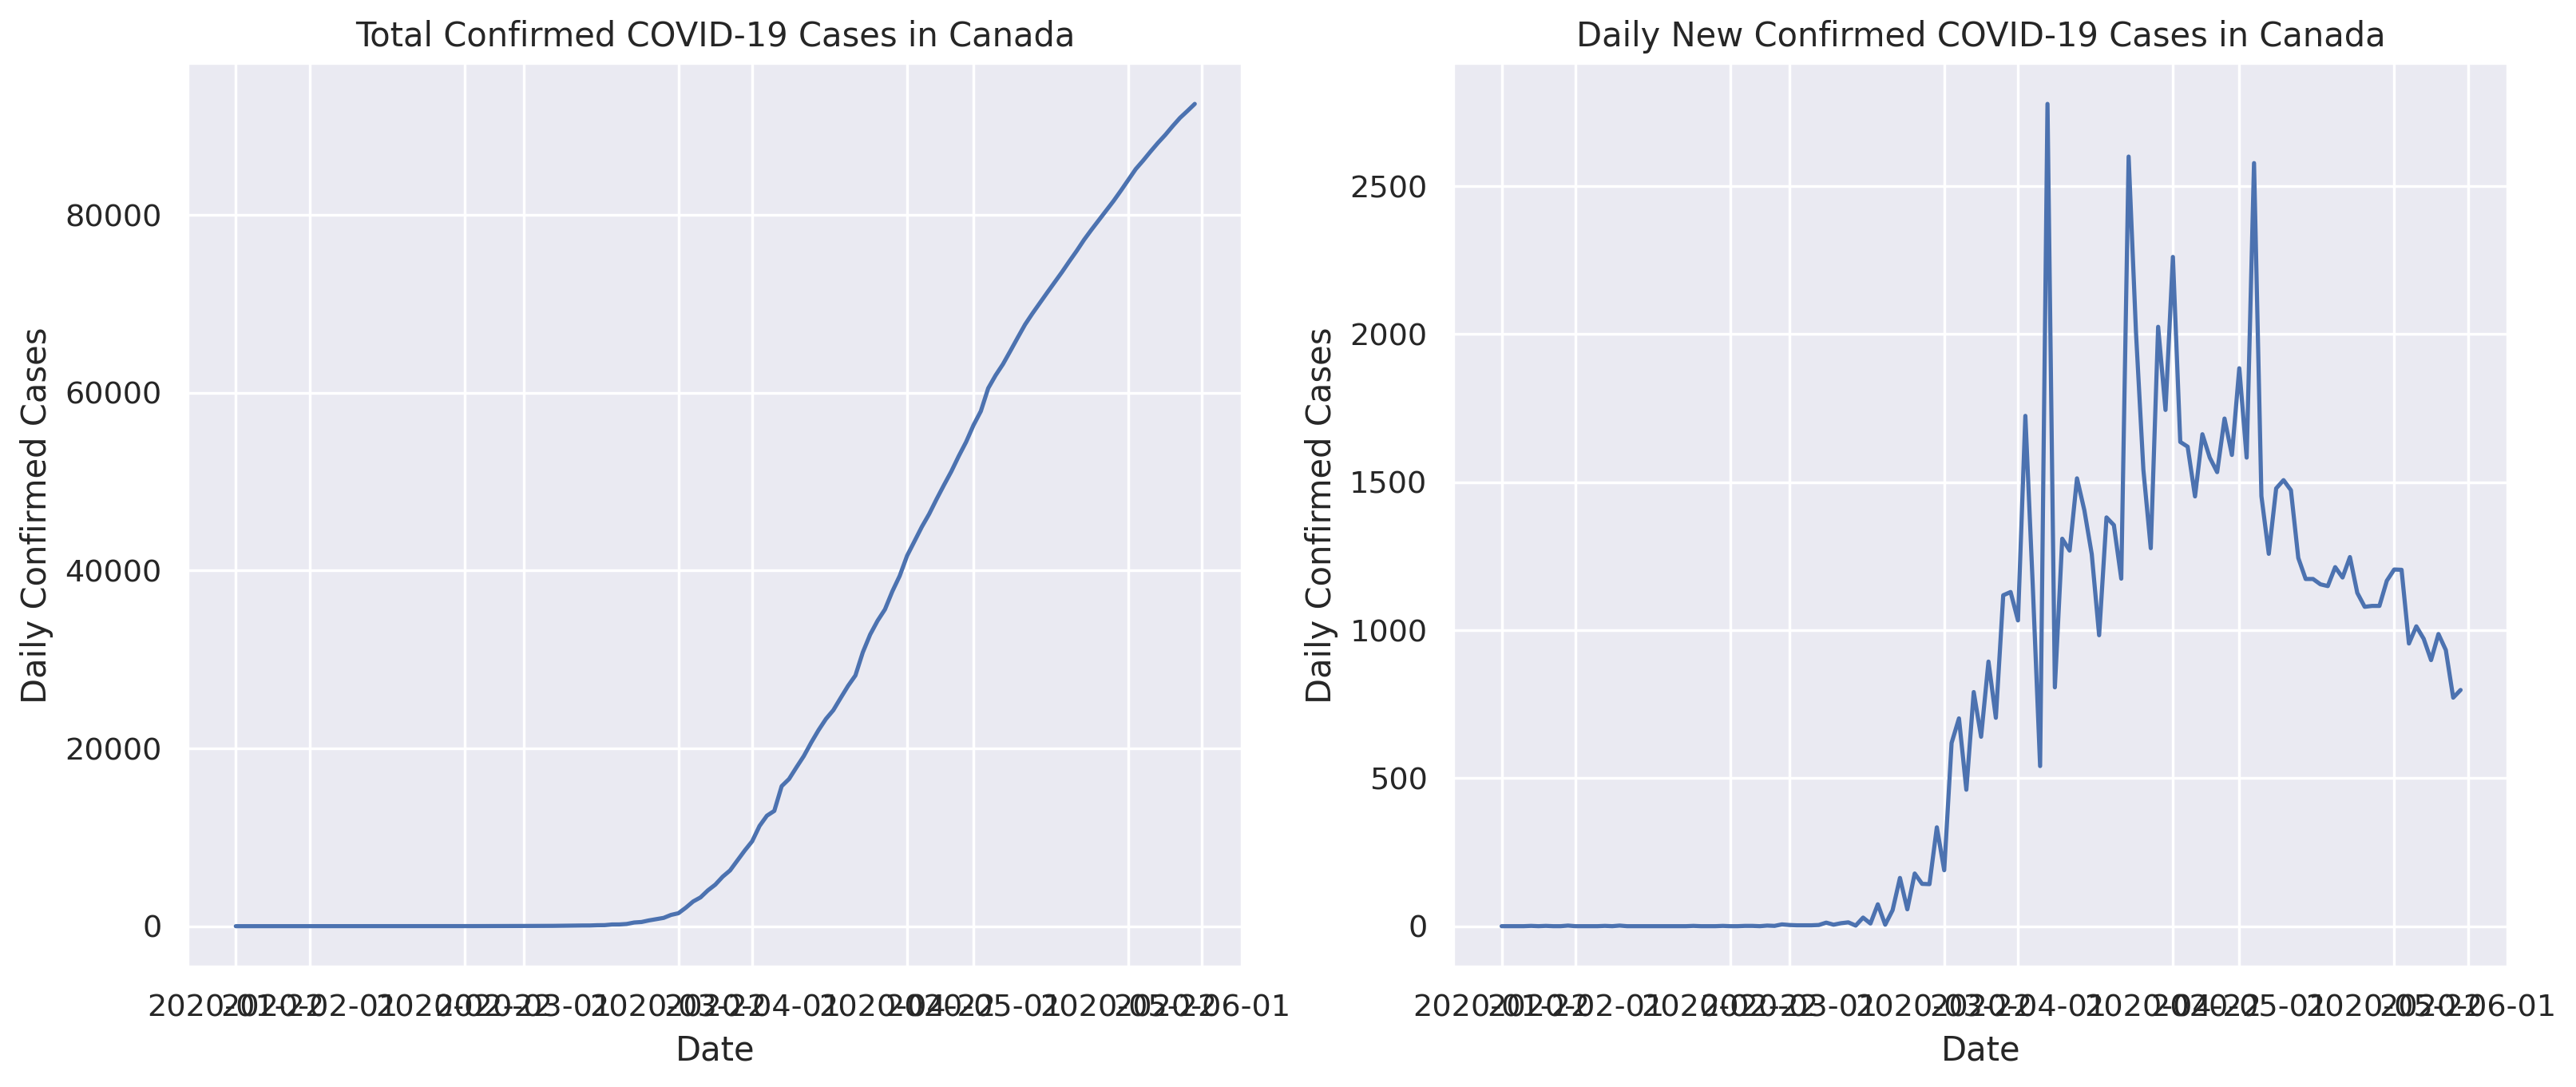

In [ ]:
cad = create_country("Canada", end_date = "2020-05-31")

In [ ]:
cad_start = "2020-04-01" # 13 confirmed cases
cad = cad[cad.date >= cad_start].reset_index(drop = True)
cad["days_since_start"] = np.arange(cad.shape[0]) + 1

In [ ]:
cad.shape
cad_tmp = cad[cad.date < "2020-05-31"]
cad_tmp.shape

(60, 8)

## Data for Regression

In [ ]:
# variable for data to easily swap it out:
country_ = "Canada (May 31st)"
reg_data = cad_tmp.copy()

In [ ]:
reg_data.head()

,country,date,confirmed,deaths,recovered,daily_confirmed,moving_avg,days_since_start
0,Canada,2020-04-01,9547,108,0,1033,996.00,1
1,Canada,2020-04-02,11271,138,0,1724,1251.00,2
2,Canada,2020-04-03,12424,178,0,1153,1259.75,3
3,Canada,2020-04-04,12965,217,0,541,1112.75,4
4,Canada,2020-04-05,15743,258,0,2778,1549.00,5


## Change Point Estimation in Pyro

In [ ]:
!pip install pyro-ppl
!pip install numpyro

In [ ]:
import torch

import pyro
import pyro.distributions as dist
from torch import nn
from pyro.nn import PyroModule, PyroSample

from pyro.infer import MCMC, NUTS, HMC
from pyro.infer.autoguide import AutoGuide, AutoDiagonalNormal

from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive

In [ ]:
# we should be able to have an empirical estimate for the mean of the prior for the 2nd regression bias term
# this will be something like b = log(max(daily_confirmed))

# might be able to have 1 regression model but change the data so that we have new terms for (tau < t) 
# like an interaction term

class COVID_change(PyroModule):
  def __init__(self, in_features, out_features, b1_mu, b2_mu):
    super().__init__()
    self.linear1 = PyroModule[nn.Linear](in_features, out_features, bias = False)
    self.linear1.weight = PyroSample(dist.Normal(0.5, 0.25).expand([1, 1]).to_event(1))
    self.linear1.bias = PyroSample(dist.Normal(b1_mu, 1.))
    
    # could possibly have stronger priors for the 2nd regression line, because we wont have as much data
    self.linear2 = PyroModule[nn.Linear](in_features, out_features, bias = False)
    self.linear2.weight = PyroSample(dist.Normal(0., 0.25).expand([1, 1])) #.to_event(1))
    self.linear2.bias = PyroSample(dist.Normal(b2_mu, b2_mu/4))

  def forward(self, x, y=None):
    tau = pyro.sample("tau", dist.Beta(4, 3))
    sigma = pyro.sample("sigma", dist.Uniform(0., 3.))
    # fit lm's to data based on tau
    sep = int(np.ceil(tau.detach().numpy() * len(x)))
    mean1 = self.linear1(x[:sep]).squeeze(-1)
    mean2 = self.linear2(x[sep:]).squeeze(-1)
    mean = torch.cat((mean1, mean2))
    obs = pyro.sample("obs", dist.StudentT(2, mean, sigma), obs=y)
    return mean

In [ ]:
tensor_data = torch.tensor(reg_data[["confirmed", "days_since_start", "daily_confirmed"]].values, dtype=torch.float)
x_data = tensor_data[:, 1].unsqueeze_(1)
y_data = np.log(tensor_data[:, 0])
y_data_daily = np.log(tensor_data[:, 2])
# prior hyper params
# take log of the average of the 1st quartile to get the prior mean for the bias of the 2nd regression line
q1 = np.quantile(y_data, q = 0.25)
bias_1_mean = np.mean(y_data.numpy()[y_data <= q1])
print("Prior mean for Bias 1: ", bias_1_mean)

# take log of the average of the 4th quartile to get the prior mean for the bias of the 2nd regression line
q4 = np.quantile(y_data, q = 0.75)
bias_2_mean = np.mean(y_data.numpy()[y_data >= q4])
print("Prior mean for Bias 2: ", bias_2_mean)

Prior mean for Bias 1:  9.807537
Prior mean for Bias 2:  11.346226


## Approximate Inference with Stochastic Variational Inference

In [ ]:
model = COVID_change(1, 
            1, 
            b1_mu = bias_1_mean,
            b2_mu = bias_2_mean)
auto_guide = AutoDiagonalNormal(model)
svi = SVI(model = model, # bayesian regression class
          guide = auto_guide, # using auto guide
          optim = pyro.optim.Adam({"lr": 0.1}), # optimizer
          loss=Trace_ELBO()) # loss function

num_iterations = 10000
# param_store is where pyro stores param estimates
pyro.clear_param_store()
# inference loop
for j in range(num_iterations):
  # calculate the loss and take a gradient step
  loss = svi.step(x_data, y_data)
  if j % 750 == 0:
    print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(y_data)))

# examine the optimized parameter values by fetching from Pyro's param store 
auto_guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
  print(name,pyro.param(name))


num_samples = 100
predictive = Predictive(model = model, 
             guide = auto_guide, 
             num_samples = num_samples,
             return_sites=("linear1.weight", 
                    "linear1.bias", 
                    "linear2.weight",
                    "linear2.bias", 
                    "tau",
                    "sigma",
                    "_RETURN",
                    "obs"))
samples = predictive(x_data)

pred_summary = summary(samples)
mu = pred_summary["_RETURN"] # mean
y = pred_summary["obs"] # samples from likelihood: mu + sigma

predictions = pd.DataFrame({
    "days_since_start": x_data[:, 0],
    "mu_mean": mu["mean"],    # mean of likelihood
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],      # mean of likelihood + noise
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_daily_confirmed": y_data,
})
predictions.head()

[iteration 0001] loss: 5.1308
[iteration 0751] loss: 1.4159
[iteration 1501] loss: 1.3008
[iteration 2251] loss: 2.2725
[iteration 3001] loss: 2.8686
[iteration 3751] loss: 2.5241
[iteration 4501] loss: 1.6854
[iteration 5251] loss: 1.4377
[iteration 6001] loss: 2.1712
[iteration 6751] loss: 1.7412
[iteration 7501] loss: 1.4311
[iteration 8251] loss: 1.2535
[iteration 9001] loss: 0.9032
[iteration 9751] loss: 1.4874
AutoDiagonalNormal.loc Parameter containing:
tensor([ 0.8819, -0.5172,  0.0496,  9.3510,  0.0414, 10.3847])
AutoDiagonalNormal.scale tensor([0.9390, 0.1492, 0.0046, 0.1258, 0.0083, 0.1881])


,days_since_start,mu_mean,mu_perc_5,mu_perc_95,y_mean,y_perc_5,y_perc_95,true_daily_confirmed
0,1.0,9.392577,9.181941,9.597135,9.658218,6.789012,12.588908,9.163982
1,2.0,9.441943,9.223634,9.642225,9.636375,4.917880,14.179121,9.329988
2,3.0,9.491307,9.266374,9.693090,8.987527,5.701207,12.320090,9.427385
3,4.0,9.540672,9.309114,9.745106,9.931319,7.166108,12.853266,9.470009
4,5.0,9.590037,9.351853,9.797120,10.496241,4.174848,14.114688,9.664151


In [ ]:
auto_guide.quantiles([0.25, 0.5, 0.75])

{'linear1.bias': [tensor(9.2661), tensor(9.3510), tensor(9.4359)],
 'linear1.weight': [tensor([[0.0464]]),
  tensor([[0.0496]]),
  tensor([[0.0527]])],
 'linear2.bias': [tensor(10.2578), tensor(10.3847), tensor(10.5115)],
 'linear2.weight': [tensor([[0.0358]]),
  tensor([[0.0414]]),
  tensor([[0.0470]])],
 'sigma': [tensor(1.0508), tensor(1.1205), tensor(1.1920)],
 'tau': [tensor(0.5618), tensor(0.7072), tensor(0.8198)]}

# HMC with NUTS

In [ ]:
model = COVID_change(1, 1, 
            b1_mu = bias_1_mean,
            b2_mu = bias_2_mean)
# need more than 400 samples/chain if we want to use a flat prior on b_2 and w_2
num_samples =400 
# mcmc 
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, 
            num_samples=num_samples,
            warmup_steps = 100, 
            num_chains = 1)
mcmc.run(x_data, y_data)
samples = mcmc.get_samples()

Sample: 100%|██████████| 500/500 [20:37,  2.47s/it, step size=1.65e-04, acc. prob=0.853]


In [ ]:
# extract individual posteriors
weight_1_post = samples["linear1.weight"].detach().numpy()
weight_2_post = samples["linear2.weight"].detach().numpy()
bias_1_post = samples["linear1.bias"].detach().numpy()
bias_2_post = samples["linear2.bias"].detach().numpy()
tau_post = samples["tau"].detach().numpy()
sigma_post = samples["sigma"].detach().numpy()

# build likelihood distribution:
tau_days = list(map(int, np.ceil(tau_post * len(x_data))))
mean_ = torch.zeros(len(tau_days), len(x_data))
obs_ = torch.zeros(len(tau_days), len(x_data))
for i in range(len(tau_days)) : 
  mean_[i, :] = torch.cat((x_data[:tau_days[i]] * weight_1_post[i] + bias_1_post[i],
                x_data[tau_days[i]:] * weight_2_post[i] + bias_2_post[i])).reshape(len(x_data))
  obs_[i, :] = dist.Normal(mean_[i, :], sigma_post[i]).sample()
samples["_RETURN"] = mean_
samples["obs"] = obs_
pred_summary = summary(samples)
mu = pred_summary["_RETURN"] # mean
y = pred_summary["obs"] # samples from likelihood: mu + sigma
y_shift = np.exp(y["mean"]) - np.exp(torch.cat((y["mean"][0:1], y["mean"][:-1])))
print(y_shift)
predictions = pd.DataFrame({
    "days_since_start": x_data[:, 0],
    "mu_mean": mu["mean"],    # mean of likelihood
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],      # mean of likelihood + noise
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_confirmed": y_data,
    "true_daily_confirmed": y_data_daily,
    "y_daily_mean": y_shift
})

w1_ = pred_summary["linear1.weight"]
w2_ = pred_summary["linear2.weight"]

b1_ = pred_summary["linear1.bias"]
b2_ = pred_summary["linear2.bias"]

tau_ = pred_summary["tau"]
sigma_ = pred_summary["sigma"]

ind = int(np.ceil(tau_["mean"] * len(x_data)))

tensor([    0.0000,   799.1621,   712.9150,   790.9199,   945.6846,   797.4512,
         1010.3281,   873.0996,  1190.0703,   932.2598,  1199.5820,  1219.3906,
         1329.7812,  1204.1055,  1380.1816,  1443.7656,  1570.0625,  1519.4102,
         1863.7930,  1676.8047,  2215.0820,  1780.2344,  2046.2109,  2083.1680,
         2558.5039,  2611.5117,  2529.9805,  1615.3867,  1452.4102,  1750.3008,
          921.5586,  1174.1523,  1280.0938,  1558.5156,  1015.0859,  1696.0508,
         1467.5117,  1778.9141,   939.7422,  1612.9609,  1827.9375,  1443.2891,
         1363.4688,    99.6797,  1048.0859,  1969.6719,  1189.4062,  1210.9766,
          999.6328, -1932.4922,  -449.6953,  1839.6562,  2237.0078,  2955.1094,
         1381.2812,  2665.6719,  2245.3359,  2252.5938,  2806.7812,  2289.4609])


## Model Diagnostics

- Residual plots: Should these be samples from the likelihood compared with the actual data? Or just the mean of the likelihood?
- $\hat{R}$: The factor that the scale of the current distribution will be reduced by if we were to run the simulations forever. As n tends to $\inf$, $\hat{R}$ tends to 1. So we want values close to 1.
- Mixing and Stationarity: I sampled 4 chains. Do I then take these chains, split them in half and plot them. If they converge to the same stationary distribution, does that mean the MCMC converged? What do I do with more sampled chains?

In [ ]:
mcmc.summary()
diag = mcmc.diagnostics()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                tau      0.54      0.15      0.45      0.42      0.82      3.54      1.52
              sigma      0.05      0.04      0.03      0.02      0.11      3.71      1.46
linear1.weight[0,0]      0.05      0.01      0.05      0.04      0.06      3.69      1.49
       linear1.bias      9.48      0.10      9.44      9.39      9.67      4.04      1.43
linear2.weight[0,0]      0.03      0.02      0.02      0.01      0.06      4.63      1.30
       linear2.bias      9.94      1.08     10.48      7.98     10.66      4.67      1.30

Number of divergences: 0


## Posterior Plots

33
2020-05-04 00:00:00


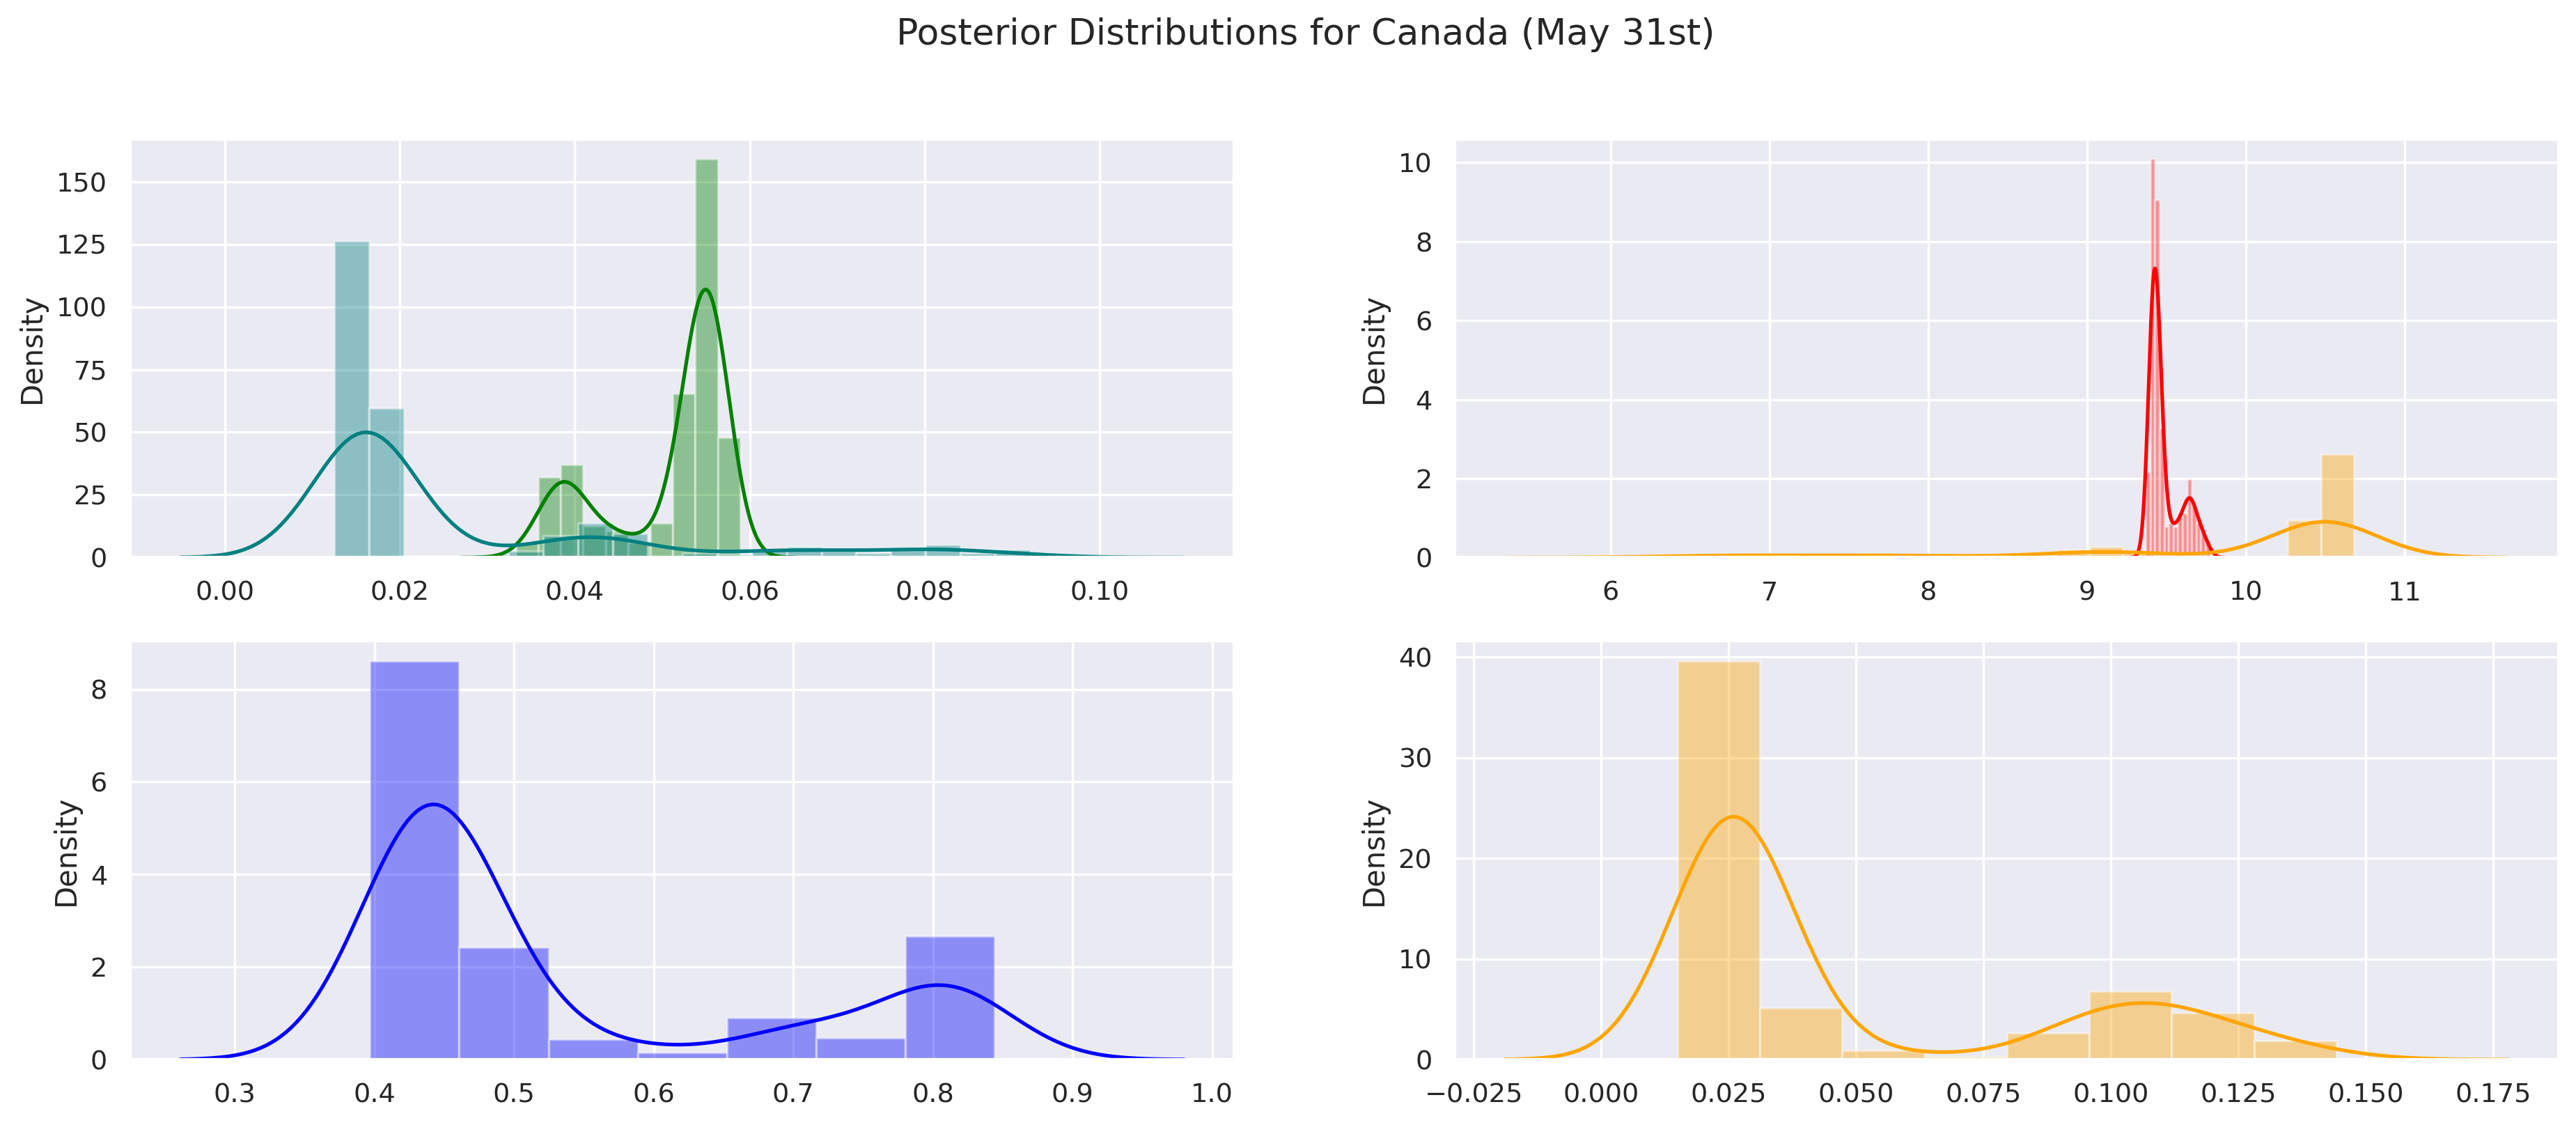

In [ ]:
print(ind)
print(reg_data.date[ind])

fig, ax = plt.subplots(2,2, figsize=(18, 7))
plt.suptitle("Posterior Distributions for %s"%country_, fontsize=15)

sns.distplot(weight_1_post, 
       kde_kws = {"label": "Weight 1"}, 
       color = "green",
       norm_hist = True,
       kde = True,
       ax = ax[0, 0])
#ax[0, 0].axvline(x = w1_["mean"], linestyle = '--')

sns.distplot(weight_2_post, 
       kde_kws = {"label": "Weight 2"}, 
       color = "teal",
       norm_hist = True,
       kde = True,
       ax = ax[0, 0])
#ax[0, 0].axvline(x = w2_["mean"], linestyle = '--')

sns.distplot(bias_1_post, 
       kde_kws = {"label": "Bias 1"}, 
       color = "red",
       norm_hist = True,
       kde = True,
       ax = ax[0, 1]);
#ax[0, 1].axvline(x = b1_["mean"], linestyle = '--')

sns.distplot(bias_2_post, 
       kde_kws = {"label": "Bias 2"}, 
       color = "orange",
       norm_hist = True,
       kde = True,
       ax = ax[0, 1])
#ax[0, 1].axvline(x = b2_["mean"], linestyle = '--');

sns.distplot(tau_post, 
       kde_kws = {"label": "Tau"}, 
       color = "blue",
       norm_hist = True,
       kde = True,
       ax = ax[1, 0])
# ax[1, 0].axvline(x = tau_["mean"], linestyle = '--', color = "red")
# ax[1, 0].axvline(x = np.median(tau_post), linestyle = '--', color = "blue")

sns.distplot(sigma_post, 
       kde_kws = {"label": "Sigma"}, 
       color = "orange",
       norm_hist = True,
       kde = True,
       ax = ax[1,1]);
#ax[1, 1].axvline(x = sigma_["mean"], linestyle = '--');

Date of change for Canada (May 31st): 2020-05-04


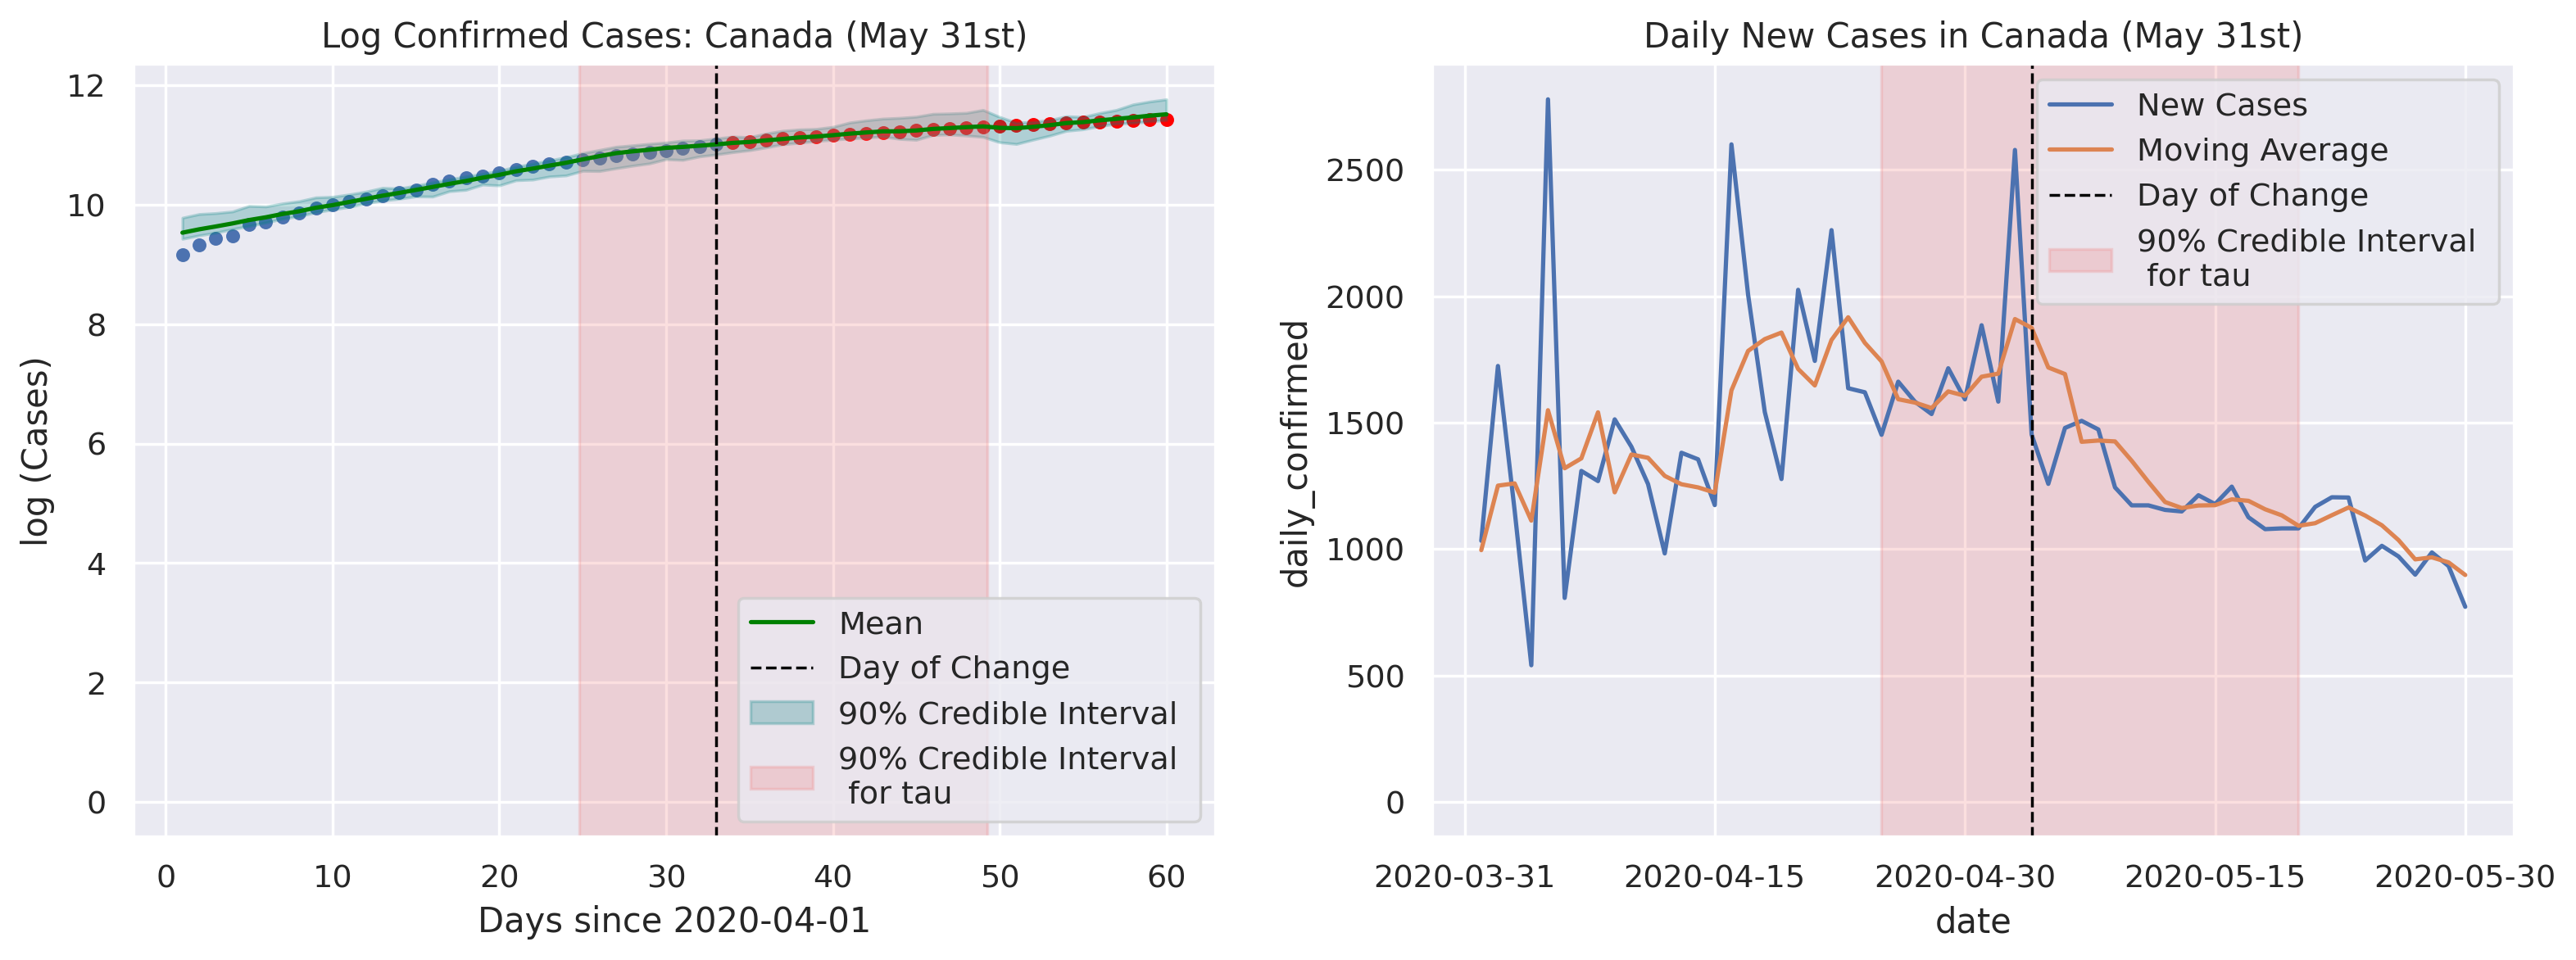

In [ ]:
start_date_ = str(reg_data.date[0]).split(' ')[0]
change_date_ = str(reg_data.date[ind]).split(' ')[0]
print("Date of change for {}: {}".format(country_, change_date_))

# plot data:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# log regression model
ax[0].scatter(y = y_data[:ind], x = x_data[:ind], s = 15);
ax[0].scatter(y = y_data[ind:], x = x_data[ind:], s = 15, color = "red");

ax[0].plot(predictions["days_since_start"],
           predictions["y_mean"], 
           color = "green",
           label = "Mean") 
ax[0].axvline(ind, 
       linestyle = '--', 
       linewidth = 1,
       label = "Day of Change",
       color = "black")
ax[0].fill_between(predictions["days_since_start"], 
          predictions["y_perc_5"], 
          predictions["y_perc_95"], 
          alpha = 0.25,
          label = "90% Credible Interval",
          color = "teal");
ax[0].fill_betweenx([0, 1], 
          tau_["5%"] * len(x_data), 
          tau_["95%"] * len(x_data), 
          alpha = 0.25,
          label = "90% Credible Interval \n for tau",
          color = "lightcoral",
          transform=ax[0].get_xaxis_transform());
ax[0].set(ylabel = "log (Cases)", 
     xlabel = "Days since %s" % start_date_, 
     title = "Log Confirmed Cases: %s" % country_)
ax[0].legend(loc = "lower right")


# plot daily confirmed cases, along with moving average
sns.lineplot(x = "date", 
       y = "daily_confirmed", 
       data = reg_data,
       label = "New Cases",
       ax = ax[1])
sns.lineplot(x = "date", 
       y = "moving_avg", 
       data = reg_data,
       label = "Moving Average",
       ax = ax[1]).set_title("Daily New Cases in %s" % country_);
ax[1].fill_betweenx([0, 1], 
          reg_data.date[int(tau_["5%"] * len(x_data))], 
          reg_data.date[int(tau_["95%"] * len(x_data))], 
          alpha = 0.25,
          label = "90% Credible Interval \n for tau",
          color = "lightcoral",
          transform=ax[1].get_xaxis_transform())
ax[1].axvline(reg_data.date[ind], 
       linestyle = '--', linewidth = 1,
       label = "Day of Change", 
       color = "black");
plt.xticks(reg_data.date)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(6)) # reduce number of xticks
ax[1].legend();

**Date of change for Canada (May 31st): 2020-05-04**

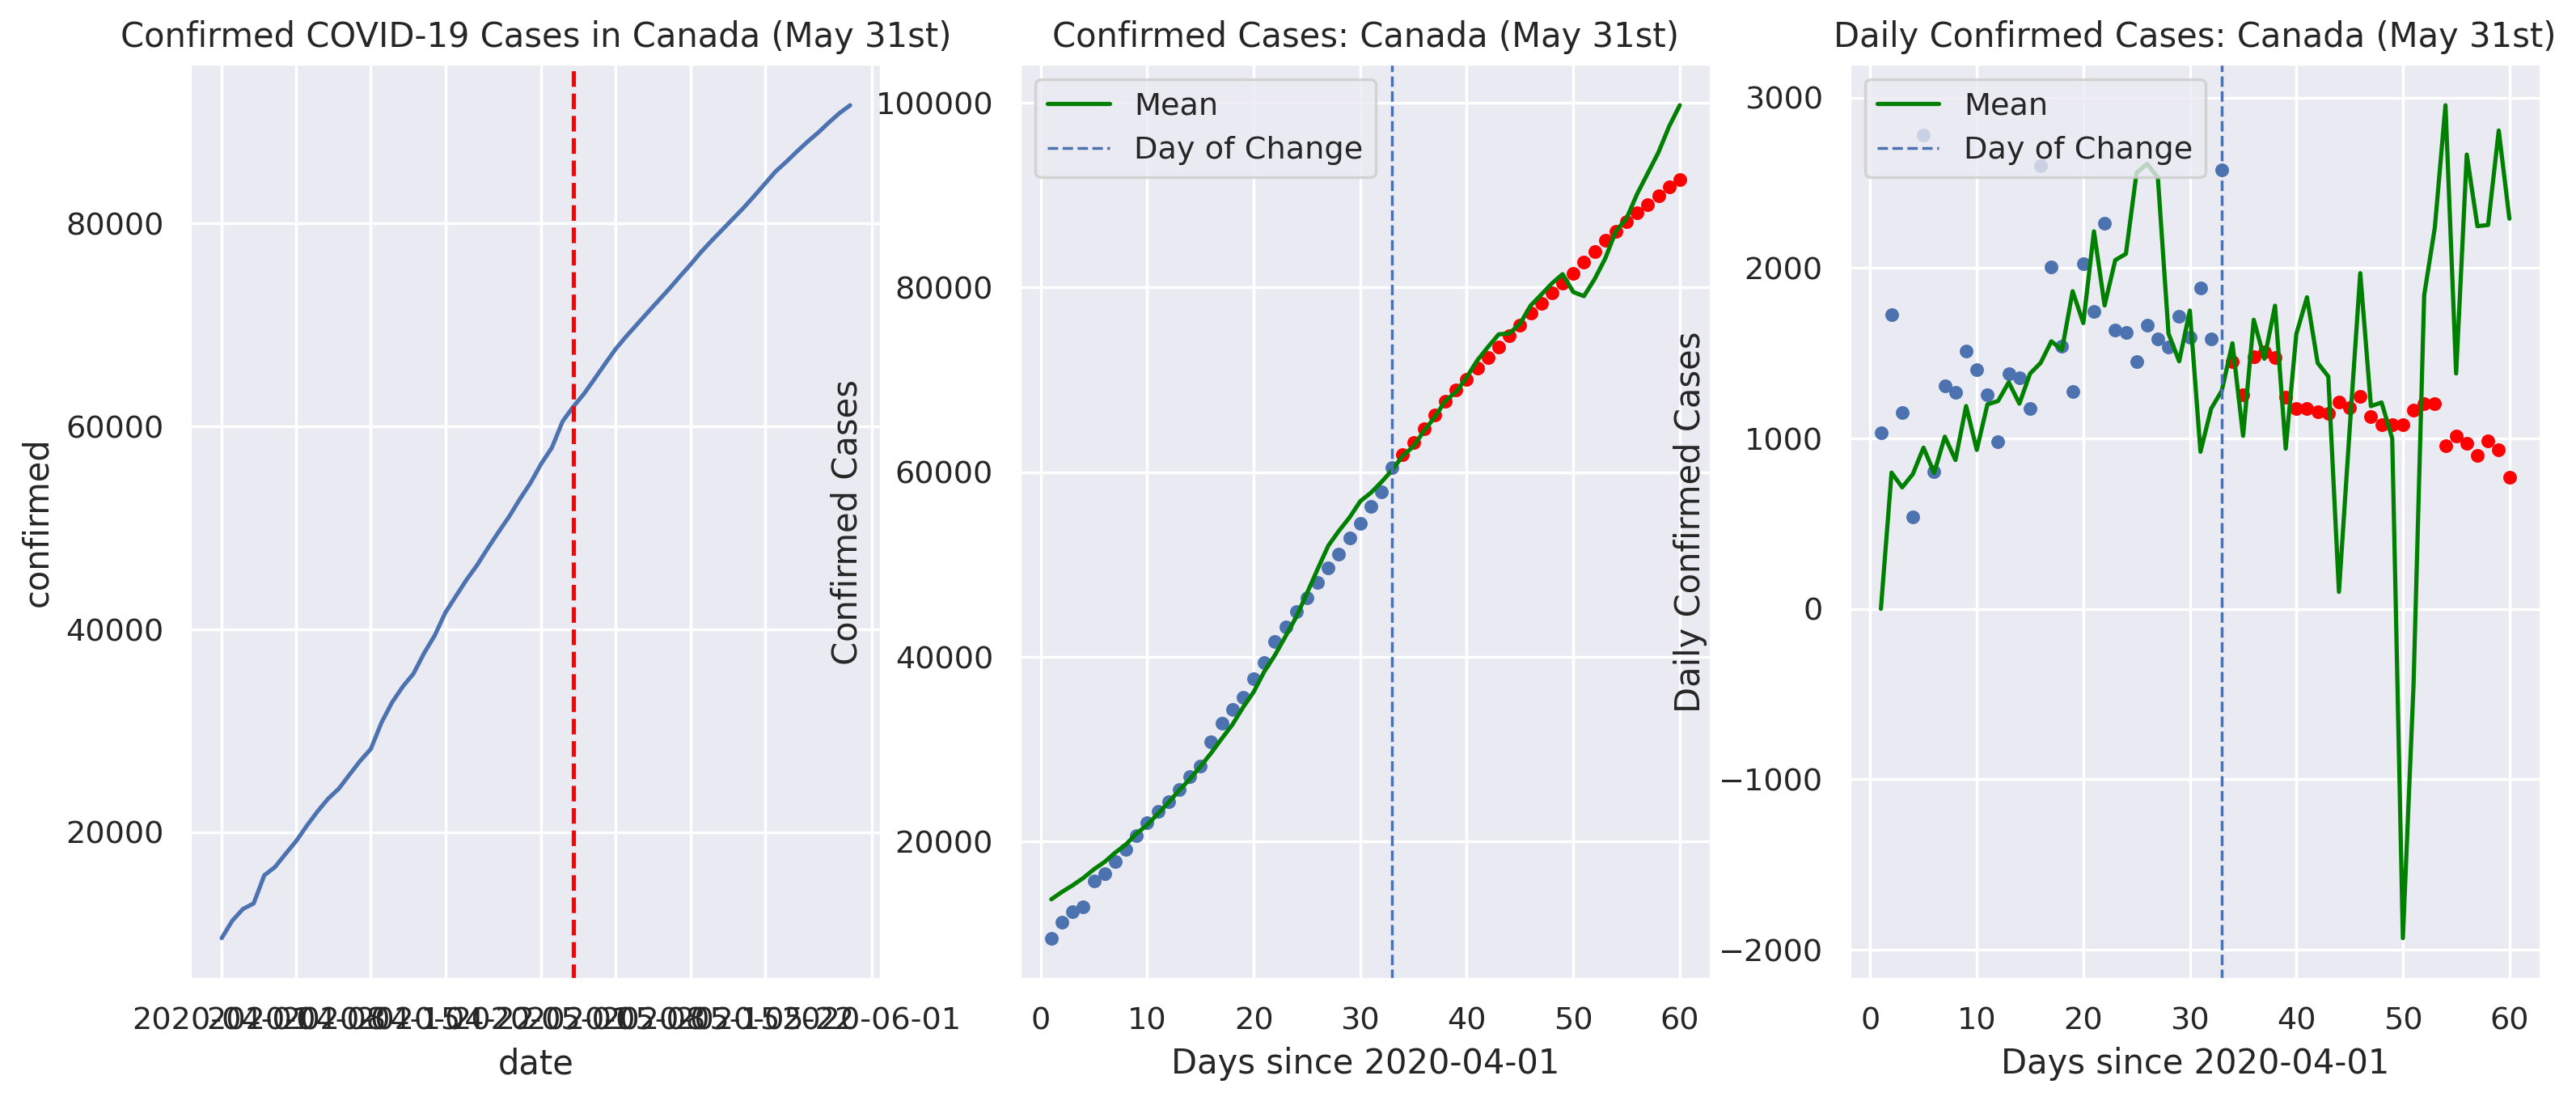

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15, 6))

#plt.figure(figsize=(11, 5))
sns.lineplot(x="date", 
       y="confirmed", 
       data= reg_data,
       ax = ax[0]
       ).set_title("Confirmed COVID-19 Cases in %s" % country_)
ax[0].axvline(reg_data.date[ind], color="red", linestyle="--")
ax[1].scatter(y = reg_data.confirmed[:ind], x = x_data[:ind], s = 15);
ax[1].scatter(y = reg_data.confirmed[ind:], x = x_data[ind:], s = 15, color = "red");

ax[1].plot(predictions["days_since_start"],
      np.exp(predictions["y_mean"]), 
      color = "green",
      label = "Mean") 
ax[1].axvline(ind, linestyle = '--', 
       linewidth = 1,
       label = "Day of Change")
ax[1].legend(loc = "upper left")
ax[1].set(ylabel = "Confirmed Cases", 
     xlabel = "Days since %s" % start_date_,
     title = "Confirmed Cases: %s" % country_);


ax[2].scatter(y = reg_data.daily_confirmed[:ind], x = x_data[:ind], s = 15);
ax[2].scatter(y = reg_data.daily_confirmed[ind:], x = x_data[ind:], s = 15, color = "red");

ax[2].plot(predictions["days_since_start"],
      predictions["y_daily_mean"], 
      color = "green",
      label = "Mean") 

ax[2].axvline(ind, linestyle = '--', 
       linewidth = 1,
       label = "Day of Change")
ax[2].legend(loc = "upper left")
ax[2].set(ylabel = "Daily Confirmed Cases", 
     xlabel = "Days since %s" % start_date_,
     title = "Daily Confirmed Cases: %s" % country_);
printmd("**Date of change for {}: {}**".format(country_, change_date_));